In [7]:
import gymnasium as gym
import numpy as np

from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise


In [6]:

env = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array")

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Hyperparamètres
learning_rate = 0.001
buffer_size = 200000
gamma = 0.98  # Discount factor
learning_starts = 10000
batch_size = 64
noise_std = 0.1  # Bruit pour exploration
actor_critic_size = [400, 300]  # Taille du réseau pour l'actor et le critic
n_steps = 50  # Nombre de pas pour chaque environnement dans lequel l'agent est entraîné
max_epochs = 10000  # Nombre d'époques pour l'entraînement
policy_kwargs = dict(net_arch=dict(pi=actor_critic_size, qf=actor_critic_size))
seed = 32
model = TD3(
    "MlpPolicy",            # Politique perceptron multicouche
    env,          # Remplace par ton environnement
    learning_rate=learning_rate,
    buffer_size=buffer_size,
    gamma=gamma,
    learning_starts=learning_starts,
    batch_size=batch_size,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,  # Taille des réseaux
    verbose=1,                   # Pour afficher des informations pendant l'entraînement
    train_freq=(n_steps, "step"),  # Nombre de pas pour chaque environnement dans lequel l'agent est entraîné
    seed=seed,
)
model.learn(total_timesteps=10000, log_interval=10)
model.save("td3_lunar")
vec_env = model.get_env()

del model # remove to demonstrate saving and loading

model = TD3.load("td3_lunar")

for _ in range(10):
    obs = vec_env.reset()
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, info = vec_env.step(action)
        vec_env.render()
        if dones:
            break
vec_env.close()


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 114      |
|    ep_rew_mean     | -284     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 5422     |
|    time_elapsed    | 0        |
|    total_timesteps | 1140     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 104      |
|    ep_rew_mean     | -267     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 5660     |
|    time_elapsed    | 0        |
|    total_timesteps | 2079     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 102      |
|    ep_rew_mean     | -247     |
| time/              |          |
|    episodes        | 30       |
|    fps             |

In [8]:
import os
from stable_baselines3.common.callbacks import BaseCallback
import stable_baselines3.common.results_plotter as rp
import torch
import torch.nn as nn
import stable_baselines3.common.monitor as mn
from tqdm import tqdm


In [15]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
  """
  Callback for saving a model (the check is done every ``check_freq`` steps)
  based on the training reward (in practice, we recommend using ``EvalCallback``).

  :param check_freq: (int)
  :param log_dir: (str) Path to the folder where the model will be saved.
    It must contains the file created by the ``Monitor`` wrapper.
  :param verbose: (int)
  """
  def __init__(self, check_freq: int, log_dir: str, verbose=1):
    super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
    self.check_freq = check_freq
    self.log_dir = log_dir
    self.save_path = os.path.join(log_dir, 'best_model')
    self.best_mean_reward = -np.inf
    self.pbar = None

  def _init_callback(self) -> None:
    # Create folder if needed
    if self.save_path is not None:
      os.makedirs(self.save_path, exist_ok=True)
    # Initialize the progress bar
    self.pbar = tqdm(total=self.check_freq, desc="Training Progress", unit="step")

  def _on_step(self) -> bool:
    if self.n_calls % self.check_freq == 0:
      # Update the progress bar
      self.pbar.update(self.check_freq)
      # Retrieve training reward
      x, y = rp.ts2xy(rp.load_results(self.log_dir), 'timesteps')
      if len(x) > 0:
        # Mean training reward over the last 100 episodes
        mean_reward = np.mean(y[-100:])
        if mean_reward > self.best_mean_reward:
          self.best_mean_reward = mean_reward
          self.model.save(self.save_path)
        self.pbar.set_postfix(best_mean_reward=self.best_mean_reward, last_mean_reward=mean_reward)
    return True

  def _on_training_end(self) -> None:
    # Close the progress bar
    if self.pbar is not None:
      self.pbar.close()

In [12]:
# Log directory for training data
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create the Lunar Lander environment and monitor it
env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
env = mn.Monitor(env, log_dir)

# The noise objects for TD3
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Save the best model during training
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)


# Customize the hyperparameters for the TD3 model
model = TD3(
    "MlpPolicy",
    env,
    learning_rate=0.001,      # Learning rate
    buffer_size=200000,     # Replay buffer size
    learning_starts=10000,    # Number of steps before training starts
    gamma=0.98,              # Discount factor
    gradient_steps=-1,      # Number of gradient updates per training step
    action_noise=action_noise,  # Action noise for exploration
    verbose=0,               # Verbosity level (info)
    seed=10,                 # Random seed for reproducibility
    batch_size=64,
    policy_kwargs=dict(net_arch=[400, 300]),  # Policy network architecture
    train_freq=(50, "step"),            # Frequency of training
    device="cpu"             # Device for training ('cuda' or 'cpu')
)

In [8]:
# Start training
model.learn(total_timesteps=100000, log_interval=50, progress_bar=True, callback=callback)
model.save("td3_sb3_lunar")

Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 3995.35step/s, best_mean_reward=-184, last_mean_reward=-184]

Training Progress: 2000step [00:00, 4301.97step/s, best_mean_reward=-184, last_mean_reward=-186]                        

Training Progress: 3000step [00:00, 4385.30step/s, best_mean_reward=-184, last_mean_reward=-188]

Training Progress: 4000step [00:00, 4672.71step/s, best_mean_reward=-184, last_mean_reward=-189]

Training Progress: 5000step [00:01, 4870.48step/s, best_mean_reward=-183, last_mean_reward=-183]

Training Progress: 6000step [00:01, 4766.08step/s, best_mean_reward=-183, last_mean_reward=-189]

Training Progress: 7000step [00:01, 4803.25step/s, best_mean_reward=-183, last_mean_reward=-193]

Training Progress: 8000step [00:01, 4769.27step/s, best_mean_reward=-183, last_mean_reward=-201]

Training Progress: 9000step [00:01, 4877.42step/s, best_mean_reward=-183, last_mean_reward=-198]

Training Progress: 10000step [00:02, 4991.54step/s, best_mean_reward=-183, last_mean_reward=-199]

Training Progress: 11000step [00:06, 744.55step/s, best_mean_reward=-183, last_mean_reward=-212] 

Training Progress: 12000step [00:10, 429.76step/s, best_mean_reward=-183, last_mean_reward=-210]

Training Progress: 13000step [00:16, 284.78step/s, best_mean_reward=-183, last_mean_reward=-209]

Training Progress: 14000step [00:19, 320.37step/s, best_mean_reward=-183, last_mean_reward=-209]

Training Progress: 15000step [00:26, 226.63step/s, best_mean_reward=-183, last_mean_reward=-203]

Training Progress: 16000step [00:30, 231.74step/s, best_mean_reward=-183, last_mean_reward=-204]

Training Progress: 17000step [00:35, 226.58step/s, best_mean_reward=-183, last_mean_reward=-203]

Training Progress: 18000step [00:39, 229.03step/s, best_mean_reward=-183, last_mean_reward=-202]

Training Progress: 19000step [00:43, 242.77step/s, best_mean_reward=-183, last_mean_reward=-204]

Training Progress: 20000step [00:48, 228.19step/s, best_mean_reward=-183, last_mean_reward=-200]

Training Progress: 21000step [00:53, 207.90step/s, best_mean_reward=-183, last_mean_reward=-198]

Training Progress: 22000step [00:59, 191.70step/s, best_mean_reward=-183, last_mean_reward=-196]

Training Progress: 23000step [01:05, 189.15step/s, best_mean_reward=-183, last_mean_reward=-197]

Training Progress: 24000step [01:10, 186.98step/s, best_mean_reward=-183, last_mean_reward=-195]

Training Progress: 25000step [01:14, 201.77step/s, best_mean_reward=-183, last_mean_reward=-192]

Training Progress: 26000step [01:19, 206.83step/s, best_mean_reward=-183, last_mean_reward=-191]

Training Progress: 27000step [01:24, 202.01step/s, best_mean_reward=-183, last_mean_reward=-191]

Training Progress: 28000step [01:29, 206.78step/s, best_mean_reward=-183, last_mean_reward=-192]

Training Progress: 29000step [01:33, 210.96step/s, best_mean_reward=-183, last_mean_reward=-191]

Training Progress: 30000step [01:38, 215.00step/s, best_mean_reward=-183, last_mean_reward=-188]

Training Progress: 31000step [01:41, 235.92step/s, best_mean_reward=-183, last_mean_reward=-189]

Training Progress: 32000step [01:46, 218.79step/s, best_mean_reward=-183, last_mean_reward=-190]

Training Progress: 33000step [01:51, 218.17step/s, best_mean_reward=-183, last_mean_reward=-189]

Training Progress: 34000step [01:54, 239.74step/s, best_mean_reward=-183, last_mean_reward=-186]

Training Progress: 35000step [01:57, 260.17step/s, best_mean_reward=-183, last_mean_reward=-188]

Training Progress: 36000step [02:02, 235.78step/s, best_mean_reward=-183, last_mean_reward=-187]

Training Progress: 37000step [02:08, 219.61step/s, best_mean_reward=-183, last_mean_reward=-188]

Training Progress: 38000step [02:10, 258.21step/s, best_mean_reward=-183, last_mean_reward=-185]

Training Progress: 39000step [02:15, 235.53step/s, best_mean_reward=-182, last_mean_reward=-182]

Training Progress: 40000step [02:21, 207.81step/s, best_mean_reward=-180, last_mean_reward=-180]

Training Progress: 41000step [02:27, 195.99step/s, best_mean_reward=-178, last_mean_reward=-178]

Training Progress: 42000step [07:14, 11.15step/s, best_mean_reward=-176, last_mean_reward=-176] 

Training Progress: 43000step [07:20, 15.51step/s, best_mean_reward=-175, last_mean_reward=-175]

Training Progress: 44000step [07:24, 21.51step/s, best_mean_reward=-175, last_mean_reward=-177]

Training Progress: 45000step [07:28, 29.76step/s, best_mean_reward=-175, last_mean_reward=-175]

Training Progress: 46000step [07:32, 40.60step/s, best_mean_reward=-174, last_mean_reward=-174]

Training Progress: 47000step [07:37, 52.71step/s, best_mean_reward=-174, last_mean_reward=-174]

Training Progress: 48000step [07:42, 67.47step/s, best_mean_reward=-172, last_mean_reward=-172]

Training Progress: 49000step [07:46, 86.39step/s, best_mean_reward=-169, last_mean_reward=-169]

Training Progress: 50000step [07:51, 105.35step/s, best_mean_reward=-162, last_mean_reward=-162]

Training Progress: 51000step [07:53, 141.07step/s, best_mean_reward=-162, last_mean_reward=-162]

Training Progress: 52000step [07:58, 154.70step/s, best_mean_reward=-161, last_mean_reward=-161]

Training Progress: 53000step [08:04, 153.63step/s, best_mean_reward=-155, last_mean_reward=-155]

Training Progress: 54000step [08:08, 175.26step/s, best_mean_reward=-151, last_mean_reward=-151]

Training Progress: 55000step [08:13, 182.64step/s, best_mean_reward=-151, last_mean_reward=-151]

Training Progress: 55000step [08:13, 182.64step/s, best_mean_reward=-146, last_mean_reward=-146]

Training Progress: 56000step [08:16, 206.33step/s, best_mean_reward=-139, last_mean_reward=-139]

Training Progress: 57000step [08:21, 208.60step/s, best_mean_reward=-137, last_mean_reward=-137]

Training Progress: 58000step [08:24, 242.08step/s, best_mean_reward=-132, last_mean_reward=-132]

Training Progress: 59000step [08:32, 187.56step/s, best_mean_reward=-124, last_mean_reward=-124]

Training Progress: 60000step [08:37, 192.82step/s, best_mean_reward=-124, last_mean_reward=-124]

Training Progress: 60000step [08:37, 192.82step/s, best_mean_reward=-114, last_mean_reward=-114]

Training Progress: 61000step [08:39, 222.74step/s, best_mean_reward=-114, last_mean_reward=-114]

Training Progress: 61000step [08:39, 222.74step/s, best_mean_reward=-110, last_mean_reward=-110]

Training Progress: 62000step [08:44, 225.77step/s, best_mean_reward=-107, last_mean_reward=-107]

Training Progress: 63000step [08:51, 188.53step/s, best_mean_reward=-103, last_mean_reward=-103]

Training Progress: 64000step [08:54, 218.01step/s, best_mean_reward=-99.6, last_mean_reward=-99.6]

Training Progress: 65000step [08:58, 224.49step/s, best_mean_reward=-95.7, last_mean_reward=-95.7]

Training Progress: 66000step [09:03, 217.61step/s, best_mean_reward=-93, last_mean_reward=-93]    

Training Progress: 67000step [09:10, 191.61step/s, best_mean_reward=-87.9, last_mean_reward=-87.9]

Training Progress: 68000step [09:16, 185.14step/s, best_mean_reward=-85.8, last_mean_reward=-85.8]

Training Progress: 69000step [09:25, 153.78step/s, best_mean_reward=-81.4, last_mean_reward=-81.4]

Training Progress: 70000step [09:32, 150.69step/s, best_mean_reward=-81.2, last_mean_reward=-81.2]

Training Progress: 71000step [09:37, 156.29step/s, best_mean_reward=-78.1, last_mean_reward=-78.1]

Training Progress: 72000step [09:44, 151.71step/s, best_mean_reward=-76, last_mean_reward=-76]    

Training Progress: 73000step [09:52, 147.96step/s, best_mean_reward=-73.7, last_mean_reward=-73.7]

Training Progress: 74000step [09:59, 142.00step/s, best_mean_reward=-70.8, last_mean_reward=-70.8]

Training Progress: 75000step [10:06, 143.50step/s, best_mean_reward=-67.1, last_mean_reward=-67.1]

Training Progress: 76000step [10:14, 141.05step/s, best_mean_reward=-59.6, last_mean_reward=-59.6]

Training Progress: 77000step [10:20, 142.78step/s, best_mean_reward=-59.6, last_mean_reward=-59.6]

Training Progress: 77000step [10:20, 142.78step/s, best_mean_reward=-57.5, last_mean_reward=-57.5]

Training Progress: 78000step [10:28, 139.77step/s, best_mean_reward=-57.5, last_mean_reward=-57.7]

Training Progress: 79000step [10:35, 140.62step/s, best_mean_reward=-57.1, last_mean_reward=-57.1]

Training Progress: 80000step [10:43, 135.82step/s, best_mean_reward=-57.1, last_mean_reward=-57.1]

Training Progress: 80000step [10:43, 135.82step/s, best_mean_reward=-56.3, last_mean_reward=-56.3]

Training Progress: 81000step [10:49, 143.38step/s, best_mean_reward=-55.8, last_mean_reward=-55.8]

Training Progress: 82000step [10:53, 163.74step/s, best_mean_reward=-52.5, last_mean_reward=-52.5]

Training Progress: 83000step [11:00, 158.07step/s, best_mean_reward=-51.6, last_mean_reward=-51.6]

Training Progress: 84000step [11:07, 151.90step/s, best_mean_reward=-51.6, last_mean_reward=-51.6]

Training Progress: 84000step [11:07, 151.90step/s, best_mean_reward=-51.6, last_mean_reward=-52.1]

Training Progress: 85000step [11:13, 153.88step/s, best_mean_reward=-51.6, last_mean_reward=-51.9]

Training Progress: 86000step [11:20, 152.60step/s, best_mean_reward=-50.8, last_mean_reward=-50.8]

Training Progress: 87000step [11:26, 154.56step/s, best_mean_reward=-50.8, last_mean_reward=-51.6]

Training Progress: 88000step [11:32, 161.23step/s, best_mean_reward=-50.5, last_mean_reward=-50.5]

Training Progress: 89000step [11:37, 164.98step/s, best_mean_reward=-46.1, last_mean_reward=-46.1]

Training Progress: 90000step [11:44, 163.41step/s, best_mean_reward=-46.1, last_mean_reward=-46.6]

Training Progress: 91000step [11:50, 161.14step/s, best_mean_reward=-46.1, last_mean_reward=-46.6]

Training Progress: 92000step [11:56, 163.60step/s, best_mean_reward=-46.1, last_mean_reward=-46.1]

Training Progress: 93000step [12:02, 164.30step/s, best_mean_reward=-45.6, last_mean_reward=-45.6]

Training Progress: 94000step [12:08, 164.96step/s, best_mean_reward=-45.6, last_mean_reward=-46]  

Training Progress: 95000step [12:15, 161.01step/s, best_mean_reward=-45.6, last_mean_reward=-46.1]

Training Progress: 96000step [12:22, 155.81step/s, best_mean_reward=-45.6, last_mean_reward=-46.6]

Training Progress: 97000step [12:27, 162.66step/s, best_mean_reward=-45.6, last_mean_reward=-46.4]

Training Progress: 98000step [12:35, 147.72step/s, best_mean_reward=-44.1, last_mean_reward=-44.1]

Training Progress: 99000step [12:41, 153.51step/s, best_mean_reward=-44.1, last_mean_reward=-45.2]

Training Progress: 100000step [12:47, 157.10step/s, best_mean_reward=-43.4, last_mean_reward=-43.4]

Training Progress: 100000step [12:52, 129.49step/s, best_mean_reward=-43.4, last_mean_reward=-43.4]


In [17]:
for i in range(10): 
    # Log directory for training data
    log_dir = f"tmp/{i}/"
    os.makedirs(log_dir, exist_ok=True)

    # Create the Lunar Lander environment and monitor it
    env = gym.make('LunarLanderContinuous-v2', render_mode="rgb_array")
    env = mn.Monitor(env, log_dir)

    # The noise objects for TD3
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    # Save the best model during training
    callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)


    # Customize the hyperparameters for the TD3 model
    model = TD3(
        "MlpPolicy",
        env,
        learning_rate=0.001,      # Learning rate
        buffer_size=200000,     # Replay buffer size
        learning_starts=10000,    # Number of steps before training starts
        gamma=0.98,              # Discount factor
        gradient_steps=-1,      # Number of gradient updates per training step
        action_noise=action_noise,  # Action noise for exploration
        verbose=0,               # Verbosity level (info)
        seed=i,                 # Random seed for reproducibility
        batch_size=64,
        policy_kwargs=dict(net_arch=[400, 300]),  # Policy network architecture
        train_freq=(50, "step"),            # Frequency of training
        device="cpu"             # Device for training ('cuda' or 'cpu')
    )

    # Start training
    model.learn(total_timesteps=100000, log_interval=50, progress_bar=True, callback=callback)
    model.save("td3_sb3_lunar")

Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 3844.05step/s, best_mean_reward=-215, last_mean_reward=-215]

Training Progress: 2000step [00:00, 4288.59step/s, best_mean_reward=-190, last_mean_reward=-190]                        

Training Progress: 3000step [00:00, 4600.54step/s, best_mean_reward=-190, last_mean_reward=-212]

Training Progress: 4000step [00:00, 4844.93step/s, best_mean_reward=-190, last_mean_reward=-215]

Training Progress: 5000step [00:01, 4517.71step/s, best_mean_reward=-190, last_mean_reward=-203]

Training Progress: 6000step [00:01, 4588.97step/s, best_mean_reward=-190, last_mean_reward=-207]

Training Progress: 7000step [00:01, 4535.84step/s, best_mean_reward=-190, last_mean_reward=-200]

Training Progress: 8000step [00:01, 4680.79step/s, best_mean_reward=-190, last_mean_reward=-203]

Training Progress: 9000step [00:02, 4321.25step/s, best_mean_reward=-190, last_mean_reward=-202]

Training Progress: 10000step [00:02, 4477.49step/s, best_mean_reward=-190, last_mean_reward=-202]

Training Progress: 10000step [00:02, 4477.49step/s, best_mean_reward=-190, last_mean_reward=-195]

Training Progress: 11000step [00:06, 641.71step/s, best_mean_reward=-190, last_mean_reward=-200] 

Training Progress: 12000step [00:13, 313.75step/s, best_mean_reward=-190, last_mean_reward=-200]

Training Progress: 13000step [00:19, 244.79step/s, best_mean_reward=-190, last_mean_reward=-199]

Training Progress: 14000step [00:25, 217.08step/s, best_mean_reward=-190, last_mean_reward=-200]

Training Progress: 15000step [00:30, 214.00step/s, best_mean_reward=-190, last_mean_reward=-201]

Training Progress: 16000step [00:35, 207.11step/s, best_mean_reward=-190, last_mean_reward=-202]

Training Progress: 17000step [00:41, 192.05step/s, best_mean_reward=-190, last_mean_reward=-199]

Training Progress: 18000step [00:48, 175.60step/s, best_mean_reward=-190, last_mean_reward=-199]

Training Progress: 19000step [00:55, 168.75step/s, best_mean_reward=-190, last_mean_reward=-197]

Training Progress: 20000step [01:01, 165.61step/s, best_mean_reward=-190, last_mean_reward=-200]

Training Progress: 21000step [01:08, 155.60step/s, best_mean_reward=-190, last_mean_reward=-200]

Training Progress: 22000step [01:13, 165.12step/s, best_mean_reward=-190, last_mean_reward=-200]

Training Progress: 23000step [01:19, 167.32step/s, best_mean_reward=-190, last_mean_reward=-198]

Training Progress: 24000step [01:25, 173.11step/s, best_mean_reward=-190, last_mean_reward=-196]

Training Progress: 25000step [01:30, 177.43step/s, best_mean_reward=-190, last_mean_reward=-192]

Training Progress: 26000step [01:35, 178.38step/s, best_mean_reward=-190, last_mean_reward=-190]

Training Progress: 27000step [01:42, 170.21step/s, best_mean_reward=-190, last_mean_reward=-190]

Training Progress: 28000step [01:47, 172.79step/s, best_mean_reward=-190, last_mean_reward=-191]

Training Progress: 29000step [01:53, 172.26step/s, best_mean_reward=-190, last_mean_reward=-192]

Training Progress: 30000step [01:59, 173.01step/s, best_mean_reward=-190, last_mean_reward=-192]

Training Progress: 31000step [02:05, 171.01step/s, best_mean_reward=-190, last_mean_reward=-192]

Training Progress: 31000step [02:05, 171.01step/s, best_mean_reward=-190, last_mean_reward=-190]

Training Progress: 32000step [02:13, 157.59step/s, best_mean_reward=-187, last_mean_reward=-187]

Training Progress: 33000step [02:19, 155.56step/s, best_mean_reward=-187, last_mean_reward=-187]

Training Progress: 33000step [02:19, 155.56step/s, best_mean_reward=-184, last_mean_reward=-184]

Training Progress: 34000step [02:25, 158.02step/s, best_mean_reward=-179, last_mean_reward=-179]

Training Progress: 35000step [02:31, 160.39step/s, best_mean_reward=-178, last_mean_reward=-178]

Training Progress: 36000step [02:37, 162.16step/s, best_mean_reward=-178, last_mean_reward=-179]

Training Progress: 37000step [02:43, 169.78step/s, best_mean_reward=-178, last_mean_reward=-178]

Training Progress: 38000step [02:48, 176.86step/s, best_mean_reward=-178, last_mean_reward=-178]

Training Progress: 38000step [02:48, 176.86step/s, best_mean_reward=-173, last_mean_reward=-173]

Training Progress: 39000step [02:53, 177.52step/s, best_mean_reward=-173, last_mean_reward=-173]

Training Progress: 39000step [02:53, 177.52step/s, best_mean_reward=-170, last_mean_reward=-170]

Training Progress: 40000step [02:59, 174.13step/s, best_mean_reward=-163, last_mean_reward=-163]

Training Progress: 41000step [03:06, 167.33step/s, best_mean_reward=-161, last_mean_reward=-161]

Training Progress: 42000step [03:12, 164.47step/s, best_mean_reward=-161, last_mean_reward=-161]

Training Progress: 43000step [03:17, 174.60step/s, best_mean_reward=-161, last_mean_reward=-162]

Training Progress: 44000step [03:23, 173.76step/s, best_mean_reward=-161, last_mean_reward=-162]

Training Progress: 44000step [03:23, 173.76step/s, best_mean_reward=-160, last_mean_reward=-160]

Training Progress: 45000step [03:29, 169.68step/s, best_mean_reward=-157, last_mean_reward=-157]

Training Progress: 46000step [03:35, 171.73step/s, best_mean_reward=-153, last_mean_reward=-153]

Training Progress: 47000step [03:40, 178.67step/s, best_mean_reward=-153, last_mean_reward=-153]

Training Progress: 47000step [03:40, 178.67step/s, best_mean_reward=-143, last_mean_reward=-143]

Training Progress: 48000step [03:45, 184.95step/s, best_mean_reward=-138, last_mean_reward=-138]

Training Progress: 49000step [03:50, 190.93step/s, best_mean_reward=-134, last_mean_reward=-134]

Training Progress: 50000step [03:56, 182.62step/s, best_mean_reward=-134, last_mean_reward=-134]

Training Progress: 50000step [03:56, 182.62step/s, best_mean_reward=-134, last_mean_reward=-134]

Training Progress: 51000step [04:02, 176.68step/s, best_mean_reward=-130, last_mean_reward=-130]

Training Progress: 52000step [04:06, 186.24step/s, best_mean_reward=-130, last_mean_reward=-130]

Training Progress: 53000step [04:12, 181.52step/s, best_mean_reward=-128, last_mean_reward=-128]

Training Progress: 54000step [04:17, 188.76step/s, best_mean_reward=-128, last_mean_reward=-128]

Training Progress: 54000step [04:17, 188.76step/s, best_mean_reward=-125, last_mean_reward=-125]

Training Progress: 55000step [04:23, 185.28step/s, best_mean_reward=-122, last_mean_reward=-122]

Training Progress: 56000step [04:27, 199.75step/s, best_mean_reward=-121, last_mean_reward=-121]

Training Progress: 57000step [04:31, 204.46step/s, best_mean_reward=-116, last_mean_reward=-116]

Training Progress: 58000step [04:36, 202.15step/s, best_mean_reward=-114, last_mean_reward=-114]

Training Progress: 59000step [04:41, 204.58step/s, best_mean_reward=-111, last_mean_reward=-111]

Training Progress: 60000step [04:47, 189.04step/s, best_mean_reward=-111, last_mean_reward=-111]

Training Progress: 60000step [04:47, 189.04step/s, best_mean_reward=-100, last_mean_reward=-100]

Training Progress: 61000step [04:53, 183.81step/s, best_mean_reward=-93.7, last_mean_reward=-93.7]

Training Progress: 62000step [04:58, 190.26step/s, best_mean_reward=-93.7, last_mean_reward=-93.7]

Training Progress: 62000step [04:58, 190.26step/s, best_mean_reward=-87.8, last_mean_reward=-87.8]

Training Progress: 63000step [05:03, 192.63step/s, best_mean_reward=-84.4, last_mean_reward=-84.4]

Training Progress: 64000step [05:08, 198.92step/s, best_mean_reward=-84.4, last_mean_reward=-87.5]

Training Progress: 65000step [05:13, 196.70step/s, best_mean_reward=-83.7, last_mean_reward=-83.7]

Training Progress: 66000step [05:18, 193.27step/s, best_mean_reward=-83.7, last_mean_reward=-84]  

Training Progress: 67000step [05:23, 202.63step/s, best_mean_reward=-81.9, last_mean_reward=-81.9]

Training Progress: 68000step [05:27, 206.93step/s, best_mean_reward=-81.9, last_mean_reward=-81.9]

Training Progress: 69000step [05:33, 195.98step/s, best_mean_reward=-79.2, last_mean_reward=-79.2]

Training Progress: 70000step [05:37, 205.01step/s, best_mean_reward=-74.7, last_mean_reward=-74.7]

Training Progress: 71000step [05:42, 211.51step/s, best_mean_reward=-68, last_mean_reward=-68]    

Training Progress: 72000step [05:47, 208.03step/s, best_mean_reward=-67.5, last_mean_reward=-67.5]

Training Progress: 73000step [05:51, 212.69step/s, best_mean_reward=-64.6, last_mean_reward=-64.6]

Training Progress: 74000step [05:56, 205.90step/s, best_mean_reward=-58.9, last_mean_reward=-58.9]

Training Progress: 75000step [06:01, 204.58step/s, best_mean_reward=-58.9, last_mean_reward=-58.9]

Training Progress: 75000step [06:01, 204.58step/s, best_mean_reward=-58.4, last_mean_reward=-58.4]

Training Progress: 76000step [06:06, 201.64step/s, best_mean_reward=-58.2, last_mean_reward=-58.2]

Training Progress: 77000step [06:13, 188.35step/s, best_mean_reward=-57.9, last_mean_reward=-57.9]

Training Progress: 78000step [06:18, 188.50step/s, best_mean_reward=-54.4, last_mean_reward=-54.4]

Training Progress: 79000step [06:24, 183.32step/s, best_mean_reward=-51.5, last_mean_reward=-51.5]

Training Progress: 80000step [06:30, 177.47step/s, best_mean_reward=-51.5, last_mean_reward=-51.6]

Training Progress: 81000step [06:36, 168.89step/s, best_mean_reward=-51.3, last_mean_reward=-51.3]

Training Progress: 82000step [06:42, 168.62step/s, best_mean_reward=-49.8, last_mean_reward=-49.8]

Training Progress: 83000step [06:48, 171.37step/s, best_mean_reward=-49.3, last_mean_reward=-49.3]

Training Progress: 84000step [06:54, 170.41step/s, best_mean_reward=-49.1, last_mean_reward=-49.1]

Training Progress: 85000step [07:00, 168.62step/s, best_mean_reward=-46.4, last_mean_reward=-46.4]

Training Progress: 86000step [07:06, 165.57step/s, best_mean_reward=-45.7, last_mean_reward=-45.7]

Training Progress: 87000step [07:12, 166.73step/s, best_mean_reward=-43.9, last_mean_reward=-43.9]

Training Progress: 88000step [07:18, 168.20step/s, best_mean_reward=-43.3, last_mean_reward=-43.3]

Training Progress: 89000step [07:25, 156.28step/s, best_mean_reward=-43.3, last_mean_reward=-46.4]

Training Progress: 90000step [07:31, 161.75step/s, best_mean_reward=-43.3, last_mean_reward=-45.1]

Training Progress: 91000step [07:37, 160.80step/s, best_mean_reward=-40.7, last_mean_reward=-40.7]

Training Progress: 92000step [07:43, 161.53step/s, best_mean_reward=-34, last_mean_reward=-34]    

Training Progress: 93000step [07:49, 168.10step/s, best_mean_reward=-31, last_mean_reward=-31]

Training Progress: 94000step [07:54, 176.20step/s, best_mean_reward=-28.4, last_mean_reward=-28.4]

Training Progress: 95000step [07:59, 179.11step/s, best_mean_reward=-27.7, last_mean_reward=-27.7]

Training Progress: 96000step [08:05, 173.71step/s, best_mean_reward=-27.7, last_mean_reward=-27.7]

Training Progress: 96000step [08:05, 173.71step/s, best_mean_reward=-26.7, last_mean_reward=-26.7]

Training Progress: 97000step [08:11, 179.31step/s, best_mean_reward=-20.2, last_mean_reward=-20.2]

Training Progress: 98000step [08:16, 178.54step/s, best_mean_reward=-18.2, last_mean_reward=-18.2]

Training Progress: 99000step [08:22, 177.69step/s, best_mean_reward=-17.4, last_mean_reward=-17.4]

Training Progress: 100000step [08:28, 169.95step/s, best_mean_reward=-17.4, last_mean_reward=-17.6]

Training Progress: 100000step [08:29, 196.39step/s, best_mean_reward=-17.4, last_mean_reward=-17.6]


Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 4918.40step/s, best_mean_reward=-212, last_mean_reward=-212]

Training Progress: 2000step [00:00, 4806.18step/s, best_mean_reward=-212, last_mean_reward=-258]                        

Training Progress: 3000step [00:00, 4801.50step/s, best_mean_reward=-212, last_mean_reward=-256]

Training Progress: 4000step [00:00, 4361.51step/s, best_mean_reward=-212, last_mean_reward=-241]

Training Progress: 5000step [00:01, 4563.12step/s, best_mean_reward=-212, last_mean_reward=-225]

Training Progress: 6000step [00:01, 4780.56step/s, best_mean_reward=-212, last_mean_reward=-222]

Training Progress: 7000step [00:01, 4850.78step/s, best_mean_reward=-212, last_mean_reward=-224]

Training Progress: 8000step [00:01, 4871.79step/s, best_mean_reward=-212, last_mean_reward=-223]

Training Progress: 9000step [00:01, 4863.33step/s, best_mean_reward=-212, last_mean_reward=-219]

Training Progress: 10000step [00:02, 4529.60step/s, best_mean_reward=-212, last_mean_reward=-216]

Training Progress: 11000step [00:06, 633.17step/s, best_mean_reward=-212, last_mean_reward=-217] 

Training Progress: 12000step [00:11, 374.92step/s, best_mean_reward=-212, last_mean_reward=-216]

Training Progress: 13000step [00:17, 279.00step/s, best_mean_reward=-212, last_mean_reward=-215]

Training Progress: 14000step [00:24, 223.17step/s, best_mean_reward=-212, last_mean_reward=-215]

Training Progress: 14000step [00:24, 223.17step/s, best_mean_reward=-212, last_mean_reward=-213]

Training Progress: 15000step [00:30, 197.22step/s, best_mean_reward=-212, last_mean_reward=-212]

Training Progress: 16000step [00:37, 181.07step/s, best_mean_reward=-212, last_mean_reward=-212]

Training Progress: 17000step [00:43, 174.84step/s, best_mean_reward=-212, last_mean_reward=-212]

Training Progress: 17000step [00:43, 174.84step/s, best_mean_reward=-211, last_mean_reward=-211]

Training Progress: 18000step [00:48, 177.17step/s, best_mean_reward=-204, last_mean_reward=-204]

Training Progress: 19000step [00:53, 183.07step/s, best_mean_reward=-201, last_mean_reward=-201]

Training Progress: 20000step [00:59, 181.02step/s, best_mean_reward=-193, last_mean_reward=-193]

Training Progress: 21000step [01:04, 187.69step/s, best_mean_reward=-187, last_mean_reward=-187]

Training Progress: 22000step [01:09, 191.01step/s, best_mean_reward=-187, last_mean_reward=-187]

Training Progress: 22000step [01:09, 191.01step/s, best_mean_reward=-182, last_mean_reward=-182]

Training Progress: 23000step [01:14, 192.52step/s, best_mean_reward=-180, last_mean_reward=-180]

Training Progress: 24000step [01:20, 187.27step/s, best_mean_reward=-174, last_mean_reward=-174]

Training Progress: 25000step [01:25, 184.46step/s, best_mean_reward=-171, last_mean_reward=-171]

Training Progress: 26000step [01:32, 173.38step/s, best_mean_reward=-170, last_mean_reward=-170]

Training Progress: 27000step [01:38, 169.32step/s, best_mean_reward=-165, last_mean_reward=-165]

Training Progress: 28000step [01:45, 161.96step/s, best_mean_reward=-164, last_mean_reward=-164]

Training Progress: 29000step [01:51, 164.00step/s, best_mean_reward=-164, last_mean_reward=-165]

Training Progress: 30000step [01:57, 166.01step/s, best_mean_reward=-164, last_mean_reward=-164]

Training Progress: 31000step [02:02, 168.45step/s, best_mean_reward=-163, last_mean_reward=-163]

Training Progress: 32000step [02:10, 158.56step/s, best_mean_reward=-162, last_mean_reward=-162]

Training Progress: 33000step [02:15, 163.54step/s, best_mean_reward=-160, last_mean_reward=-160]

Training Progress: 34000step [02:22, 156.27step/s, best_mean_reward=-158, last_mean_reward=-158]

Training Progress: 35000step [02:30, 147.87step/s, best_mean_reward=-156, last_mean_reward=-156]

Training Progress: 36000step [02:38, 139.31step/s, best_mean_reward=-155, last_mean_reward=-155]

Training Progress: 37000step [02:44, 144.86step/s, best_mean_reward=-155, last_mean_reward=-157]

Training Progress: 38000step [02:50, 152.94step/s, best_mean_reward=-155, last_mean_reward=-159]

Training Progress: 39000step [02:55, 164.30step/s, best_mean_reward=-148, last_mean_reward=-148]

Training Progress: 40000step [03:00, 170.82step/s, best_mean_reward=-139, last_mean_reward=-139]

Training Progress: 41000step [03:06, 173.07step/s, best_mean_reward=-128, last_mean_reward=-128]

Training Progress: 42000step [03:12, 175.06step/s, best_mean_reward=-126, last_mean_reward=-126]

Training Progress: 43000step [03:17, 181.57step/s, best_mean_reward=-116, last_mean_reward=-116]

Training Progress: 44000step [03:22, 186.35step/s, best_mean_reward=-108, last_mean_reward=-108]

Training Progress: 45000step [03:27, 184.92step/s, best_mean_reward=-98.4, last_mean_reward=-98.4]

Training Progress: 46000step [03:32, 185.81step/s, best_mean_reward=-92.6, last_mean_reward=-92.6]

Training Progress: 47000step [03:38, 184.07step/s, best_mean_reward=-92.6, last_mean_reward=-92.6]

Training Progress: 47000step [03:38, 184.07step/s, best_mean_reward=-83.6, last_mean_reward=-83.6]

Training Progress: 48000step [03:43, 184.18step/s, best_mean_reward=-78.4, last_mean_reward=-78.4]

Training Progress: 49000step [03:49, 179.03step/s, best_mean_reward=-78.4, last_mean_reward=-78.4]

Training Progress: 49000step [03:49, 179.03step/s, best_mean_reward=-70.8, last_mean_reward=-70.8]

Training Progress: 50000step [03:55, 175.58step/s, best_mean_reward=-70.8, last_mean_reward=-70.8]

Training Progress: 50000step [03:55, 175.58step/s, best_mean_reward=-64.8, last_mean_reward=-64.8]

Training Progress: 51000step [04:01, 180.41step/s, best_mean_reward=-64.8, last_mean_reward=-64.8]

Training Progress: 51000step [04:01, 180.41step/s, best_mean_reward=-61.3, last_mean_reward=-61.3]

Training Progress: 52000step [04:06, 177.89step/s, best_mean_reward=-57.9, last_mean_reward=-57.9]

Training Progress: 53000step [04:13, 170.18step/s, best_mean_reward=-54.4, last_mean_reward=-54.4]

Training Progress: 54000step [04:19, 171.23step/s, best_mean_reward=-54.4, last_mean_reward=-55.6]

Training Progress: 55000step [04:25, 167.33step/s, best_mean_reward=-50.6, last_mean_reward=-50.6]

Training Progress: 56000step [04:30, 170.92step/s, best_mean_reward=-50.5, last_mean_reward=-50.5]

Training Progress: 57000step [04:36, 170.25step/s, best_mean_reward=-49.1, last_mean_reward=-49.1]

Training Progress: 58000step [04:42, 171.84step/s, best_mean_reward=-42.5, last_mean_reward=-42.5]

Training Progress: 59000step [04:48, 172.70step/s, best_mean_reward=-36.3, last_mean_reward=-36.3]

Training Progress: 60000step [04:53, 176.68step/s, best_mean_reward=-32.5, last_mean_reward=-32.5]

Training Progress: 61000step [04:59, 178.80step/s, best_mean_reward=-28.7, last_mean_reward=-28.7]

Training Progress: 62000step [05:06, 164.78step/s, best_mean_reward=-28.3, last_mean_reward=-28.3]

Training Progress: 63000step [05:13, 154.04step/s, best_mean_reward=-28.1, last_mean_reward=-28.1]

Training Progress: 64000step [05:21, 143.56step/s, best_mean_reward=-27.3, last_mean_reward=-27.3]

Training Progress: 65000step [05:29, 141.15step/s, best_mean_reward=-24.7, last_mean_reward=-24.7]

Training Progress: 66000step [05:35, 142.92step/s, best_mean_reward=-24.7, last_mean_reward=-26.3]

Training Progress: 67000step [05:41, 149.14step/s, best_mean_reward=-24.7, last_mean_reward=-25.7]

Training Progress: 68000step [05:48, 153.15step/s, best_mean_reward=-24.7, last_mean_reward=-24.8]

Training Progress: 69000step [05:54, 156.48step/s, best_mean_reward=-23.7, last_mean_reward=-23.7]

Training Progress: 70000step [05:59, 162.11step/s, best_mean_reward=-22.7, last_mean_reward=-22.7]

Training Progress: 71000step [06:05, 162.63step/s, best_mean_reward=-22.6, last_mean_reward=-22.6]

Training Progress: 72000step [06:12, 158.25step/s, best_mean_reward=-22.6, last_mean_reward=-22.6]

Training Progress: 72000step [06:12, 158.25step/s, best_mean_reward=-21.2, last_mean_reward=-21.2]

Training Progress: 73000step [06:19, 154.21step/s, best_mean_reward=-21.2, last_mean_reward=-23.4]

Training Progress: 74000step [06:26, 153.68step/s, best_mean_reward=-21.2, last_mean_reward=-21.9]

Training Progress: 75000step [06:32, 157.44step/s, best_mean_reward=-21.2, last_mean_reward=-21.9]

Training Progress: 75000step [06:32, 157.44step/s, best_mean_reward=-19.3, last_mean_reward=-19.3]

Training Progress: 76000step [06:38, 155.47step/s, best_mean_reward=-17.7, last_mean_reward=-17.7]

Training Progress: 77000step [06:44, 158.89step/s, best_mean_reward=-16.6, last_mean_reward=-16.6]

Training Progress: 78000step [06:50, 162.61step/s, best_mean_reward=-11.6, last_mean_reward=-11.6]

Training Progress: 79000step [06:57, 154.97step/s, best_mean_reward=-11.6, last_mean_reward=-11.8]

Training Progress: 80000step [07:03, 160.13step/s, best_mean_reward=-11.6, last_mean_reward=-11.8]

Training Progress: 80000step [07:03, 160.13step/s, best_mean_reward=-10.6, last_mean_reward=-10.6]

Training Progress: 81000step [07:09, 157.86step/s, best_mean_reward=-10.4, last_mean_reward=-10.4]

Training Progress: 82000step [07:16, 154.88step/s, best_mean_reward=-10.4, last_mean_reward=-12.2]

Training Progress: 83000step [07:22, 162.24step/s, best_mean_reward=-10.4, last_mean_reward=-14.1]

Training Progress: 84000step [07:28, 157.09step/s, best_mean_reward=-10.4, last_mean_reward=-13]  

Training Progress: 85000step [07:34, 160.94step/s, best_mean_reward=-10.4, last_mean_reward=-12.6]

Training Progress: 86000step [07:40, 164.25step/s, best_mean_reward=-10.4, last_mean_reward=-11.5]

Training Progress: 87000step [07:46, 166.37step/s, best_mean_reward=-10.4, last_mean_reward=-12]  

Training Progress: 88000step [07:52, 166.06step/s, best_mean_reward=-10.4, last_mean_reward=-11.5]

Training Progress: 89000step [07:57, 172.07step/s, best_mean_reward=-8.78, last_mean_reward=-8.78]

Training Progress: 90000step [08:02, 180.56step/s, best_mean_reward=-5.18, last_mean_reward=-5.18]

Training Progress: 91000step [08:08, 180.68step/s, best_mean_reward=-3.69, last_mean_reward=-3.69]

Training Progress: 92000step [08:14, 175.80step/s, best_mean_reward=-3.56, last_mean_reward=-3.56]

Training Progress: 93000step [08:21, 165.52step/s, best_mean_reward=-3.56, last_mean_reward=-3.56]

Training Progress: 93000step [08:21, 165.52step/s, best_mean_reward=-1.27, last_mean_reward=-1.27]

Training Progress: 94000step [08:27, 164.08step/s, best_mean_reward=-1.14, last_mean_reward=-1.14]

Training Progress: 95000step [08:34, 152.71step/s, best_mean_reward=-1.14, last_mean_reward=-1.14]

Training Progress: 95000step [08:34, 152.71step/s, best_mean_reward=-.681, last_mean_reward=-.681]

Training Progress: 96000step [08:41, 156.12step/s, best_mean_reward=-.681, last_mean_reward=-.848]

Training Progress: 97000step [08:47, 159.10step/s, best_mean_reward=3.41, last_mean_reward=3.41]  

Training Progress: 98000step [08:53, 158.69step/s, best_mean_reward=8.94, last_mean_reward=8.94]

Training Progress: 99000step [08:58, 166.83step/s, best_mean_reward=8.94, last_mean_reward=8.94]

Training Progress: 99000step [08:58, 166.83step/s, best_mean_reward=10.8, last_mean_reward=10.8]

Training Progress: 100000step [09:03, 173.07step/s, best_mean_reward=10.8, last_mean_reward=10.2]

Training Progress: 100000step [09:04, 183.77step/s, best_mean_reward=10.8, last_mean_reward=10.2]


Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 3574.36step/s, best_mean_reward=-232, last_mean_reward=-232]

Training Progress: 2000step [00:00, 3529.13step/s, best_mean_reward=-232, last_mean_reward=-267]                        

Training Progress: 3000step [00:00, 4162.96step/s, best_mean_reward=-232, last_mean_reward=-270]

Training Progress: 4000step [00:00, 4422.99step/s, best_mean_reward=-232, last_mean_reward=-258]

Training Progress: 5000step [00:01, 4599.53step/s, best_mean_reward=-232, last_mean_reward=-251]

Training Progress: 6000step [00:01, 4822.95step/s, best_mean_reward=-232, last_mean_reward=-257]

Training Progress: 7000step [00:01, 4874.24step/s, best_mean_reward=-232, last_mean_reward=-254]

Training Progress: 8000step [00:01, 4585.03step/s, best_mean_reward=-232, last_mean_reward=-249]

Training Progress: 9000step [00:02, 4549.52step/s, best_mean_reward=-232, last_mean_reward=-254]

Training Progress: 10000step [00:02, 4655.24step/s, best_mean_reward=-232, last_mean_reward=-251]

Training Progress: 11000step [00:06, 675.04step/s, best_mean_reward=-232, last_mean_reward=-250] 

Training Progress: 12000step [00:13, 318.06step/s, best_mean_reward=-232, last_mean_reward=-249]

Training Progress: 13000step [00:21, 223.57step/s, best_mean_reward=-232, last_mean_reward=-248]

Training Progress: 14000step [00:28, 181.71step/s, best_mean_reward=-232, last_mean_reward=-246]

Training Progress: 15000step [00:35, 171.21step/s, best_mean_reward=-232, last_mean_reward=-245]

Training Progress: 16000step [00:42, 162.43step/s, best_mean_reward=-232, last_mean_reward=-243]

Training Progress: 17000step [00:49, 153.07step/s, best_mean_reward=-232, last_mean_reward=-243]

Training Progress: 18000step [00:57, 147.97step/s, best_mean_reward=-232, last_mean_reward=-241]

Training Progress: 19000step [01:03, 153.76step/s, best_mean_reward=-232, last_mean_reward=-240]

Training Progress: 20000step [01:09, 151.31step/s, best_mean_reward=-232, last_mean_reward=-239]

Training Progress: 21000step [01:16, 153.02step/s, best_mean_reward=-232, last_mean_reward=-235]

Training Progress: 22000step [01:22, 156.01step/s, best_mean_reward=-232, last_mean_reward=-233]

Training Progress: 23000step [01:29, 152.83step/s, best_mean_reward=-232, last_mean_reward=-232]

Training Progress: 24000step [01:35, 151.75step/s, best_mean_reward=-229, last_mean_reward=-229]

Training Progress: 25000step [01:42, 149.71step/s, best_mean_reward=-222, last_mean_reward=-222]

Training Progress: 26000step [01:48, 158.46step/s, best_mean_reward=-220, last_mean_reward=-220]

Training Progress: 27000step [01:53, 168.60step/s, best_mean_reward=-220, last_mean_reward=-220]

Training Progress: 27000step [01:53, 168.60step/s, best_mean_reward=-210, last_mean_reward=-210]

Training Progress: 28000step [01:59, 163.79step/s, best_mean_reward=-210, last_mean_reward=-210]

Training Progress: 28000step [01:59, 163.79step/s, best_mean_reward=-205, last_mean_reward=-205]

Training Progress: 29000step [02:06, 160.64step/s, best_mean_reward=-205, last_mean_reward=-206]

Training Progress: 30000step [02:11, 167.64step/s, best_mean_reward=-202, last_mean_reward=-202]

Training Progress: 31000step [02:17, 169.19step/s, best_mean_reward=-202, last_mean_reward=-202]

Training Progress: 31000step [02:17, 169.19step/s, best_mean_reward=-192, last_mean_reward=-192]

Training Progress: 32000step [02:23, 170.64step/s, best_mean_reward=-189, last_mean_reward=-189]

Training Progress: 33000step [02:28, 176.02step/s, best_mean_reward=-184, last_mean_reward=-184]

Training Progress: 34000step [02:35, 168.11step/s, best_mean_reward=-184, last_mean_reward=-184]

Training Progress: 35000step [02:41, 162.78step/s, best_mean_reward=-183, last_mean_reward=-183]

Training Progress: 36000step [02:47, 166.33step/s, best_mean_reward=-176, last_mean_reward=-176]

Training Progress: 37000step [02:53, 165.21step/s, best_mean_reward=-176, last_mean_reward=-176]

Training Progress: 37000step [02:53, 165.21step/s, best_mean_reward=-173, last_mean_reward=-173]

Training Progress: 38000step [03:01, 153.06step/s, best_mean_reward=-172, last_mean_reward=-172]

Training Progress: 39000step [03:06, 158.79step/s, best_mean_reward=-166, last_mean_reward=-166]

Training Progress: 40000step [03:12, 161.94step/s, best_mean_reward=-156, last_mean_reward=-156]

Training Progress: 41000step [03:17, 175.03step/s, best_mean_reward=-139, last_mean_reward=-139]

Training Progress: 42000step [03:23, 176.24step/s, best_mean_reward=-130, last_mean_reward=-130]

Training Progress: 43000step [03:28, 177.06step/s, best_mean_reward=-117, last_mean_reward=-117]

Training Progress: 44000step [03:33, 186.70step/s, best_mean_reward=-114, last_mean_reward=-114]

Training Progress: 45000step [03:38, 187.77step/s, best_mean_reward=-107, last_mean_reward=-107]

Training Progress: 46000step [03:44, 179.68step/s, best_mean_reward=-102, last_mean_reward=-102]

Training Progress: 47000step [03:50, 179.95step/s, best_mean_reward=-101, last_mean_reward=-101]

Training Progress: 48000step [03:57, 166.69step/s, best_mean_reward=-100, last_mean_reward=-100]

Training Progress: 49000step [04:03, 162.66step/s, best_mean_reward=-97.6, last_mean_reward=-97.6]

Training Progress: 50000step [04:09, 166.43step/s, best_mean_reward=-92.6, last_mean_reward=-92.6]

Training Progress: 51000step [04:13, 182.90step/s, best_mean_reward=-79.9, last_mean_reward=-79.9]

Training Progress: 52000step [04:18, 188.10step/s, best_mean_reward=-66.7, last_mean_reward=-66.7]

Training Progress: 53000step [04:23, 195.59step/s, best_mean_reward=-57.8, last_mean_reward=-57.8]

Training Progress: 54000step [04:28, 190.26step/s, best_mean_reward=-46.2, last_mean_reward=-46.2]

Training Progress: 55000step [04:34, 183.43step/s, best_mean_reward=-46.2, last_mean_reward=-46.2]

Training Progress: 55000step [04:34, 183.43step/s, best_mean_reward=-42.7, last_mean_reward=-42.7]

Training Progress: 56000step [04:40, 182.89step/s, best_mean_reward=-34.2, last_mean_reward=-34.2]

Training Progress: 57000step [04:46, 176.19step/s, best_mean_reward=-26.7, last_mean_reward=-26.7]

Training Progress: 58000step [04:51, 180.15step/s, best_mean_reward=-24.5, last_mean_reward=-24.5]

Training Progress: 59000step [04:57, 174.28step/s, best_mean_reward=-18.7, last_mean_reward=-18.7]

Training Progress: 60000step [05:04, 162.74step/s, best_mean_reward=-14.3, last_mean_reward=-14.3]

Training Progress: 61000step [05:10, 170.30step/s, best_mean_reward=-13.3, last_mean_reward=-13.3]

Training Progress: 62000step [05:16, 166.22step/s, best_mean_reward=-11.3, last_mean_reward=-11.3]

Training Progress: 63000step [05:23, 158.22step/s, best_mean_reward=-8.57, last_mean_reward=-8.57]

Training Progress: 64000step [05:31, 149.03step/s, best_mean_reward=-8.57, last_mean_reward=-8.57]

Training Progress: 64000step [05:31, 149.03step/s, best_mean_reward=-7.85, last_mean_reward=-7.85]

Training Progress: 65000step [05:38, 147.45step/s, best_mean_reward=-7.34, last_mean_reward=-7.34]

Training Progress: 66000step [05:45, 145.89step/s, best_mean_reward=-6.62, last_mean_reward=-6.62]

Training Progress: 67000step [05:51, 151.62step/s, best_mean_reward=-6.08, last_mean_reward=-6.08]

Training Progress: 68000step [05:57, 153.33step/s, best_mean_reward=-6.08, last_mean_reward=-6.08]

Training Progress: 68000step [05:57, 153.33step/s, best_mean_reward=-5.88, last_mean_reward=-5.88]

Training Progress: 69000step [06:05, 146.28step/s, best_mean_reward=-4.79, last_mean_reward=-4.79]

Training Progress: 70000step [06:13, 134.07step/s, best_mean_reward=-4.35, last_mean_reward=-4.35]

Training Progress: 71000step [06:23, 122.92step/s, best_mean_reward=-4.35, last_mean_reward=-4.39]

Training Progress: 72000step [06:29, 132.28step/s, best_mean_reward=-4.35, last_mean_reward=-4.39]

Training Progress: 72000step [06:29, 132.28step/s, best_mean_reward=-3.35, last_mean_reward=-3.35]

Training Progress: 73000step [06:37, 132.75step/s, best_mean_reward=-2.71, last_mean_reward=-2.71]

Training Progress: 74000step [06:43, 142.11step/s, best_mean_reward=0.0525, last_mean_reward=0.0525]

Training Progress: 75000step [06:49, 147.12step/s, best_mean_reward=0.267, last_mean_reward=0.267]  

Training Progress: 76000step [06:55, 155.62step/s, best_mean_reward=0.267, last_mean_reward=-.672]

Training Progress: 77000step [06:59, 167.95step/s, best_mean_reward=0.267, last_mean_reward=-.442]

Training Progress: 78000step [07:05, 172.44step/s, best_mean_reward=0.267, last_mean_reward=-.442]

Training Progress: 78000step [07:05, 172.44step/s, best_mean_reward=2.6, last_mean_reward=2.6]    

Training Progress: 79000step [07:13, 154.31step/s, best_mean_reward=3.36, last_mean_reward=3.36]

Training Progress: 80000step [07:19, 153.46step/s, best_mean_reward=3.36, last_mean_reward=3.23]

Training Progress: 81000step [07:27, 149.19step/s, best_mean_reward=4.21, last_mean_reward=4.21]

Training Progress: 82000step [07:32, 157.46step/s, best_mean_reward=4.21, last_mean_reward=3.88]

Training Progress: 83000step [07:39, 151.41step/s, best_mean_reward=4.21, last_mean_reward=3.47]

Training Progress: 84000step [07:46, 150.36step/s, best_mean_reward=4.21, last_mean_reward=3.15]

Training Progress: 85000step [07:53, 150.62step/s, best_mean_reward=4.21, last_mean_reward=2.41]

Training Progress: 86000step [07:59, 150.51step/s, best_mean_reward=4.21, last_mean_reward=3.18]

Training Progress: 87000step [08:06, 149.32step/s, best_mean_reward=4.45, last_mean_reward=4.45]

Training Progress: 88000step [08:12, 155.17step/s, best_mean_reward=4.45, last_mean_reward=0.885]

Training Progress: 89000step [08:20, 143.14step/s, best_mean_reward=4.45, last_mean_reward=2.19] 

Training Progress: 90000step [08:26, 154.36step/s, best_mean_reward=4.45, last_mean_reward=1.61]

Training Progress: 91000step [08:32, 154.14step/s, best_mean_reward=4.78, last_mean_reward=4.78]

Training Progress: 92000step [08:38, 161.94step/s, best_mean_reward=7.3, last_mean_reward=7.3]  

Training Progress: 93000step [08:43, 169.45step/s, best_mean_reward=9.56, last_mean_reward=9.56]

Training Progress: 94000step [08:48, 174.06step/s, best_mean_reward=9.56, last_mean_reward=9.56]

Training Progress: 94000step [08:48, 174.06step/s, best_mean_reward=9.88, last_mean_reward=9.88]

Training Progress: 95000step [08:55, 167.65step/s, best_mean_reward=10.6, last_mean_reward=10.6]

Training Progress: 96000step [09:01, 163.26step/s, best_mean_reward=10.6, last_mean_reward=9.96]

Training Progress: 97000step [09:08, 158.29step/s, best_mean_reward=10.6, last_mean_reward=9.06]

Training Progress: 98000step [09:13, 167.73step/s, best_mean_reward=11.4, last_mean_reward=11.4]

Training Progress: 99000step [09:19, 167.75step/s, best_mean_reward=11.7, last_mean_reward=11.7]

Training Progress: 100000step [09:25, 171.83step/s, best_mean_reward=11.7, last_mean_reward=10.1]

Training Progress: 100000step [09:25, 176.91step/s, best_mean_reward=11.7, last_mean_reward=10.1]


Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 4812.46step/s]

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 4812.46step/s, best_mean_reward=-183, last_mean_reward=-183]

Training Progress: 2000step [00:00, 4410.24step/s, best_mean_reward=-183, last_mean_reward=-225]                        

Training Progress: 3000step [00:00, 4042.12step/s, best_mean_reward=-183, last_mean_reward=-214]

Training Progress: 4000step [00:01, 3653.51step/s, best_mean_reward=-183, last_mean_reward=-205]

Training Progress: 5000step [00:01, 4046.25step/s, best_mean_reward=-183, last_mean_reward=-199]

Training Progress: 6000step [00:01, 4322.12step/s, best_mean_reward=-183, last_mean_reward=-210]

Training Progress: 7000step [00:01, 4296.92step/s, best_mean_reward=-183, last_mean_reward=-212]

Training Progress: 8000step [00:01, 4303.10step/s, best_mean_reward=-183, last_mean_reward=-211]

Training Progress: 9000step [00:02, 4418.47step/s, best_mean_reward=-183, last_mean_reward=-208]

Training Progress: 10000step [00:02, 3919.15step/s, best_mean_reward=-183, last_mean_reward=-211]

Training Progress: 11000step [00:07, 584.91step/s, best_mean_reward=-183, last_mean_reward=-210] 

Training Progress: 12000step [00:13, 316.56step/s, best_mean_reward=-183, last_mean_reward=-209]

Training Progress: 13000step [00:20, 241.09step/s, best_mean_reward=-183, last_mean_reward=-209]

Training Progress: 13000step [00:20, 241.09step/s, best_mean_reward=-183, last_mean_reward=-208]

Training Progress: 14000step [00:26, 211.16step/s, best_mean_reward=-183, last_mean_reward=-207]

Training Progress: 15000step [00:31, 206.35step/s, best_mean_reward=-183, last_mean_reward=-203]

Training Progress: 16000step [00:36, 199.29step/s, best_mean_reward=-183, last_mean_reward=-203]

Training Progress: 17000step [00:42, 188.49step/s, best_mean_reward=-183, last_mean_reward=-198]

Training Progress: 18000step [00:48, 188.68step/s, best_mean_reward=-183, last_mean_reward=-197]

Training Progress: 19000step [00:53, 187.94step/s, best_mean_reward=-183, last_mean_reward=-191]

Training Progress: 20000step [00:58, 191.54step/s, best_mean_reward=-183, last_mean_reward=-189]

Training Progress: 21000step [01:03, 192.76step/s, best_mean_reward=-183, last_mean_reward=-189]

Training Progress: 21000step [01:03, 192.76step/s, best_mean_reward=-180, last_mean_reward=-180]

Training Progress: 22000step [01:09, 185.05step/s, best_mean_reward=-174, last_mean_reward=-174]

Training Progress: 23000step [01:15, 177.77step/s, best_mean_reward=-169, last_mean_reward=-169]

Training Progress: 24000step [01:21, 173.14step/s, best_mean_reward=-169, last_mean_reward=-169]

Training Progress: 24000step [01:21, 173.14step/s, best_mean_reward=-166, last_mean_reward=-166]

Training Progress: 25000step [01:27, 178.08step/s, best_mean_reward=-162, last_mean_reward=-162]

Training Progress: 26000step [01:32, 176.58step/s, best_mean_reward=-161, last_mean_reward=-161]

Training Progress: 27000step [01:38, 175.24step/s, best_mean_reward=-160, last_mean_reward=-160]

Training Progress: 28000step [01:44, 170.20step/s, best_mean_reward=-155, last_mean_reward=-155]

Training Progress: 29000step [01:50, 169.42step/s, best_mean_reward=-149, last_mean_reward=-149]

Training Progress: 30000step [01:56, 168.39step/s, best_mean_reward=-147, last_mean_reward=-147]

Training Progress: 31000step [02:02, 171.33step/s, best_mean_reward=-139, last_mean_reward=-139]

Training Progress: 32000step [02:07, 177.36step/s, best_mean_reward=-139, last_mean_reward=-140]

Training Progress: 33000step [02:13, 179.25step/s, best_mean_reward=-139, last_mean_reward=-140]

Training Progress: 33000step [02:13, 179.25step/s, best_mean_reward=-138, last_mean_reward=-138]

Training Progress: 34000step [02:18, 184.73step/s, best_mean_reward=-135, last_mean_reward=-135]

Training Progress: 35000step [02:23, 184.56step/s, best_mean_reward=-132, last_mean_reward=-132]

Training Progress: 36000step [02:28, 188.63step/s, best_mean_reward=-129, last_mean_reward=-129]

Training Progress: 37000step [02:33, 192.68step/s, best_mean_reward=-122, last_mean_reward=-122]

Training Progress: 38000step [02:38, 197.45step/s, best_mean_reward=-117, last_mean_reward=-117]

Training Progress: 39000step [02:43, 193.59step/s, best_mean_reward=-117, last_mean_reward=-117]

Training Progress: 39000step [02:43, 193.59step/s, best_mean_reward=-117, last_mean_reward=-119]

Training Progress: 40000step [02:48, 195.29step/s, best_mean_reward=-113, last_mean_reward=-113]

Training Progress: 41000step [02:55, 174.31step/s, best_mean_reward=-111, last_mean_reward=-111]

Training Progress: 42000step [03:02, 169.09step/s, best_mean_reward=-111, last_mean_reward=-111]

Training Progress: 42000step [03:02, 169.09step/s, best_mean_reward=-109, last_mean_reward=-109]

Training Progress: 43000step [03:08, 165.16step/s, best_mean_reward=-107, last_mean_reward=-107]

Training Progress: 44000step [03:14, 167.19step/s, best_mean_reward=-107, last_mean_reward=-107]

Training Progress: 44000step [03:14, 167.19step/s, best_mean_reward=-100, last_mean_reward=-100]

Training Progress: 45000step [03:19, 174.58step/s, best_mean_reward=-87.6, last_mean_reward=-87.6]

Training Progress: 46000step [03:25, 176.83step/s, best_mean_reward=-87.6, last_mean_reward=-88.2]

Training Progress: 47000step [03:30, 177.20step/s, best_mean_reward=-81.5, last_mean_reward=-81.5]

Training Progress: 48000step [03:36, 174.94step/s, best_mean_reward=-81.5, last_mean_reward=-81.5]

Training Progress: 48000step [03:36, 174.94step/s, best_mean_reward=-77.4, last_mean_reward=-77.4]

Training Progress: 49000step [03:43, 166.00step/s, best_mean_reward=-72, last_mean_reward=-72]    

Training Progress: 50000step [03:50, 155.48step/s, best_mean_reward=-72, last_mean_reward=-72]

Training Progress: 50000step [03:50, 155.48step/s, best_mean_reward=-71.6, last_mean_reward=-71.6]

Training Progress: 51000step [03:57, 151.88step/s, best_mean_reward=-64.3, last_mean_reward=-64.3]

Training Progress: 52000step [04:06, 138.76step/s, best_mean_reward=-64.3, last_mean_reward=-64.3]

Training Progress: 52000step [04:06, 138.76step/s, best_mean_reward=-60.5, last_mean_reward=-60.5]

Training Progress: 53000step [04:15, 130.38step/s, best_mean_reward=-57.6, last_mean_reward=-57.6]

Training Progress: 54000step [04:21, 139.72step/s, best_mean_reward=-53.5, last_mean_reward=-53.5]

Training Progress: 55000step [04:26, 151.82step/s, best_mean_reward=-47.6, last_mean_reward=-47.6]

Training Progress: 56000step [04:31, 159.59step/s, best_mean_reward=-40, last_mean_reward=-40]    

Training Progress: 57000step [04:37, 162.40step/s, best_mean_reward=-40, last_mean_reward=-40]

Training Progress: 57000step [04:37, 162.40step/s, best_mean_reward=-32.1, last_mean_reward=-32.1]

Training Progress: 58000step [04:44, 161.12step/s, best_mean_reward=-32.1, last_mean_reward=-32.1]

Training Progress: 58000step [04:44, 161.12step/s, best_mean_reward=-27.5, last_mean_reward=-27.5]

Training Progress: 59000step [04:50, 158.03step/s, best_mean_reward=-26.3, last_mean_reward=-26.3]

Training Progress: 60000step [04:55, 166.39step/s, best_mean_reward=-20.3, last_mean_reward=-20.3]

Training Progress: 61000step [05:01, 167.85step/s, best_mean_reward=-19, last_mean_reward=-19]    

Training Progress: 62000step [05:07, 171.42step/s, best_mean_reward=-16.6, last_mean_reward=-16.6]

Training Progress: 63000step [05:13, 172.45step/s, best_mean_reward=-14, last_mean_reward=-14]    

Training Progress: 64000step [05:20, 156.97step/s, best_mean_reward=-14, last_mean_reward=-14.3]

Training Progress: 65000step [05:26, 160.72step/s, best_mean_reward=-14, last_mean_reward=-14.4]

Training Progress: 66000step [05:32, 165.81step/s, best_mean_reward=-14, last_mean_reward=-14.4]

Training Progress: 66000step [05:32, 165.81step/s, best_mean_reward=-13.9, last_mean_reward=-13.9]

Training Progress: 67000step [05:37, 170.61step/s, best_mean_reward=-12.7, last_mean_reward=-12.7]

Training Progress: 68000step [05:45, 156.08step/s, best_mean_reward=-9.08, last_mean_reward=-9.08]

Training Progress: 69000step [05:51, 160.40step/s, best_mean_reward=-9.08, last_mean_reward=-10.5]

Training Progress: 70000step [05:56, 167.96step/s, best_mean_reward=-9.08, last_mean_reward=-9.97]

Training Progress: 71000step [06:02, 166.18step/s, best_mean_reward=-9.08, last_mean_reward=-11.7]

Training Progress: 72000step [06:09, 162.16step/s, best_mean_reward=-9.08, last_mean_reward=-9.26]

Training Progress: 73000step [06:14, 165.15step/s, best_mean_reward=-9.08, last_mean_reward=-9.86]

Training Progress: 74000step [06:20, 170.37step/s, best_mean_reward=-7.68, last_mean_reward=-7.68]

Training Progress: 75000step [06:25, 174.69step/s, best_mean_reward=-3.98, last_mean_reward=-3.98]

Training Progress: 76000step [06:31, 177.34step/s, best_mean_reward=-1.38, last_mean_reward=-1.38]

Training Progress: 77000step [06:36, 178.72step/s, best_mean_reward=-1.3, last_mean_reward=-1.3]  

Training Progress: 78000step [06:43, 165.14step/s, best_mean_reward=-1.3, last_mean_reward=-1.7]

Training Progress: 79000step [06:49, 164.87step/s, best_mean_reward=-1.3, last_mean_reward=-1.7]

Training Progress: 79000step [06:49, 164.87step/s, best_mean_reward=1.45, last_mean_reward=1.45]

Training Progress: 80000step [06:57, 155.43step/s, best_mean_reward=1.45, last_mean_reward=1.45]

Training Progress: 80000step [06:57, 155.43step/s, best_mean_reward=2.25, last_mean_reward=2.25]

Training Progress: 81000step [07:03, 155.81step/s, best_mean_reward=2.25, last_mean_reward=1.76]

Training Progress: 82000step [07:09, 157.56step/s, best_mean_reward=2.25, last_mean_reward=1.76]

Training Progress: 82000step [07:09, 157.56step/s, best_mean_reward=2.73, last_mean_reward=2.73]

Training Progress: 83000step [07:15, 163.02step/s, best_mean_reward=2.73, last_mean_reward=1.14]

Training Progress: 84000step [07:21, 166.72step/s, best_mean_reward=2.73, last_mean_reward=0.19]

Training Progress: 85000step [07:27, 164.12step/s, best_mean_reward=2.73, last_mean_reward=1.26]

Training Progress: 86000step [07:34, 157.34step/s, best_mean_reward=2.73, last_mean_reward=-.449]

Training Progress: 87000step [07:41, 150.56step/s, best_mean_reward=2.73, last_mean_reward=-.449]

Training Progress: 87000step [07:41, 150.56step/s, best_mean_reward=2.73, last_mean_reward=0.971]

Training Progress: 88000step [07:49, 141.35step/s, best_mean_reward=2.73, last_mean_reward=1.91] 

Training Progress: 89000step [07:56, 144.30step/s, best_mean_reward=4.45, last_mean_reward=4.45]

Training Progress: 90000step [08:02, 147.65step/s, best_mean_reward=10.1, last_mean_reward=10.1]

Training Progress: 91000step [08:09, 149.95step/s, best_mean_reward=12.5, last_mean_reward=12.5]

Training Progress: 92000step [08:16, 147.20step/s, best_mean_reward=13.6, last_mean_reward=13.6]

Training Progress: 93000step [08:22, 151.16step/s, best_mean_reward=15.4, last_mean_reward=15.4]

Training Progress: 94000step [08:29, 150.20step/s, best_mean_reward=17, last_mean_reward=17]    

Training Progress: 95000step [08:35, 150.01step/s, best_mean_reward=17.3, last_mean_reward=17.3]

Training Progress: 96000step [08:43, 143.82step/s, best_mean_reward=17.3, last_mean_reward=17.3]

Training Progress: 96000step [08:43, 143.82step/s, best_mean_reward=18.7, last_mean_reward=18.7]

Training Progress: 97000step [08:49, 147.59step/s, best_mean_reward=18.7, last_mean_reward=18.7]

Training Progress: 97000step [08:49, 147.59step/s, best_mean_reward=23.4, last_mean_reward=23.4]

Training Progress: 98000step [08:56, 148.03step/s, best_mean_reward=23.4, last_mean_reward=21.1]

Training Progress: 99000step [09:02, 151.88step/s, best_mean_reward=23.4, last_mean_reward=20.4]

Training Progress: 100000step [09:08, 158.65step/s, best_mean_reward=23.4, last_mean_reward=19.4]

Training Progress: 100000step [09:08, 182.24step/s, best_mean_reward=23.4, last_mean_reward=19.4]


Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 3711.11step/s, best_mean_reward=-219, last_mean_reward=-219]

Training Progress: 2000step [00:00, 3493.33step/s, best_mean_reward=-219, last_mean_reward=-219]                        

Training Progress: 2000step [00:00, 3493.33step/s, best_mean_reward=-204, last_mean_reward=-204]

Training Progress: 3000step [00:00, 3494.75step/s, best_mean_reward=-187, last_mean_reward=-187]

Training Progress: 4000step [00:01, 3812.45step/s, best_mean_reward=-187, last_mean_reward=-194]

Training Progress: 5000step [00:01, 4009.09step/s, best_mean_reward=-187, last_mean_reward=-197]

Training Progress: 6000step [00:01, 4109.65step/s, best_mean_reward=-187, last_mean_reward=-191]

Training Progress: 7000step [00:01, 3812.34step/s, best_mean_reward=-187, last_mean_reward=-188]

Training Progress: 8000step [00:02, 4167.38step/s, best_mean_reward=-176, last_mean_reward=-176]

Training Progress: 9000step [00:02, 4238.79step/s, best_mean_reward=-176, last_mean_reward=-185]

Training Progress: 10000step [00:02, 4404.74step/s, best_mean_reward=-176, last_mean_reward=-185]

Training Progress: 11000step [00:07, 632.75step/s, best_mean_reward=-176, last_mean_reward=-198] 

Training Progress: 12000step [00:13, 339.70step/s, best_mean_reward=-176, last_mean_reward=-200]

Training Progress: 13000step [00:20, 236.41step/s, best_mean_reward=-176, last_mean_reward=-198]

Training Progress: 14000step [00:25, 218.63step/s, best_mean_reward=-176, last_mean_reward=-193]

Training Progress: 15000step [00:32, 194.43step/s, best_mean_reward=-176, last_mean_reward=-190]

Training Progress: 16000step [00:37, 190.33step/s, best_mean_reward=-176, last_mean_reward=-191]

Training Progress: 17000step [00:44, 177.95step/s, best_mean_reward=-176, last_mean_reward=-189]

Training Progress: 18000step [00:49, 176.24step/s, best_mean_reward=-176, last_mean_reward=-189]

Training Progress: 19000step [00:55, 173.40step/s, best_mean_reward=-176, last_mean_reward=-189]

Training Progress: 20000step [01:01, 174.45step/s, best_mean_reward=-176, last_mean_reward=-187]

Training Progress: 21000step [01:08, 165.34step/s, best_mean_reward=-176, last_mean_reward=-185]

Training Progress: 22000step [01:14, 161.49step/s, best_mean_reward=-176, last_mean_reward=-185]

Training Progress: 23000step [01:22, 154.54step/s, best_mean_reward=-176, last_mean_reward=-183]

Training Progress: 24000step [01:28, 153.46step/s, best_mean_reward=-176, last_mean_reward=-182]

Training Progress: 25000step [01:34, 155.08step/s, best_mean_reward=-176, last_mean_reward=-182]

Training Progress: 26000step [01:40, 159.00step/s, best_mean_reward=-175, last_mean_reward=-175]

Training Progress: 27000step [01:46, 163.55step/s, best_mean_reward=-172, last_mean_reward=-172]

Training Progress: 28000step [01:52, 168.57step/s, best_mean_reward=-166, last_mean_reward=-166]

Training Progress: 29000step [01:58, 166.19step/s, best_mean_reward=-165, last_mean_reward=-165]

Training Progress: 30000step [02:04, 166.09step/s, best_mean_reward=-163, last_mean_reward=-163]

Training Progress: 31000step [02:10, 161.39step/s, best_mean_reward=-163, last_mean_reward=-163]

Training Progress: 32000step [02:16, 168.31step/s, best_mean_reward=-160, last_mean_reward=-160]

Training Progress: 33000step [02:21, 174.03step/s, best_mean_reward=-154, last_mean_reward=-154]

Training Progress: 34000step [02:27, 171.33step/s, best_mean_reward=-154, last_mean_reward=-154]

Training Progress: 35000step [02:33, 173.08step/s, best_mean_reward=-153, last_mean_reward=-153]

Training Progress: 36000step [02:39, 169.22step/s, best_mean_reward=-153, last_mean_reward=-153]

Training Progress: 36000step [02:39, 169.22step/s, best_mean_reward=-152, last_mean_reward=-152]

Training Progress: 37000step [02:47, 152.26step/s, best_mean_reward=-151, last_mean_reward=-151]

Training Progress: 38000step [02:55, 144.68step/s, best_mean_reward=-150, last_mean_reward=-150]

Training Progress: 39000step [03:02, 143.26step/s, best_mean_reward=-147, last_mean_reward=-147]

Training Progress: 40000step [03:09, 145.61step/s, best_mean_reward=-145, last_mean_reward=-145]

Training Progress: 41000step [03:14, 151.79step/s, best_mean_reward=-145, last_mean_reward=-145]

Training Progress: 42000step [03:20, 160.72step/s, best_mean_reward=-139, last_mean_reward=-139]

Training Progress: 43000step [03:26, 160.02step/s, best_mean_reward=-136, last_mean_reward=-136]

Training Progress: 44000step [03:34, 151.78step/s, best_mean_reward=-134, last_mean_reward=-134]

Training Progress: 45000step [03:41, 147.60step/s, best_mean_reward=-134, last_mean_reward=-134]

Training Progress: 46000step [03:47, 151.44step/s, best_mean_reward=-134, last_mean_reward=-134]

Training Progress: 46000step [03:47, 151.44step/s, best_mean_reward=-130, last_mean_reward=-130]

Training Progress: 47000step [03:52, 162.63step/s, best_mean_reward=-128, last_mean_reward=-128]

Training Progress: 48000step [03:58, 166.86step/s, best_mean_reward=-126, last_mean_reward=-126]

Training Progress: 49000step [04:04, 166.68step/s, best_mean_reward=-126, last_mean_reward=-126]

Training Progress: 50000step [04:09, 175.05step/s, best_mean_reward=-126, last_mean_reward=-126]

Training Progress: 50000step [04:09, 175.05step/s, best_mean_reward=-121, last_mean_reward=-121]

Training Progress: 51000step [04:14, 176.79step/s, best_mean_reward=-117, last_mean_reward=-117]

Training Progress: 52000step [04:20, 175.54step/s, best_mean_reward=-115, last_mean_reward=-115]

Training Progress: 53000step [04:27, 164.29step/s, best_mean_reward=-112, last_mean_reward=-112]

Training Progress: 54000step [04:34, 159.04step/s, best_mean_reward=-107, last_mean_reward=-107]

Training Progress: 55000step [04:40, 159.15step/s, best_mean_reward=-107, last_mean_reward=-107]

Training Progress: 55000step [04:40, 159.15step/s, best_mean_reward=-103, last_mean_reward=-103]

Training Progress: 56000step [04:47, 156.20step/s, best_mean_reward=-100, last_mean_reward=-100]

Training Progress: 57000step [04:54, 148.13step/s, best_mean_reward=-100, last_mean_reward=-101]

Training Progress: 58000step [05:01, 147.33step/s, best_mean_reward=-93.5, last_mean_reward=-93.5]

Training Progress: 59000step [05:10, 136.90step/s, best_mean_reward=-91.7, last_mean_reward=-91.7]

Training Progress: 60000step [05:17, 138.57step/s, best_mean_reward=-87.7, last_mean_reward=-87.7]

Training Progress: 61000step [05:23, 144.27step/s, best_mean_reward=-85.7, last_mean_reward=-85.7]

Training Progress: 62000step [05:29, 147.63step/s, best_mean_reward=-81.1, last_mean_reward=-81.1]

Training Progress: 63000step [05:36, 150.88step/s, best_mean_reward=-81.1, last_mean_reward=-81.1]

Training Progress: 63000step [05:36, 150.88step/s, best_mean_reward=-75.9, last_mean_reward=-75.9]

Training Progress: 64000step [05:42, 153.17step/s, best_mean_reward=-75.9, last_mean_reward=-76.1]

Training Progress: 65000step [05:48, 155.70step/s, best_mean_reward=-75.9, last_mean_reward=-77.1]

Training Progress: 66000step [05:54, 160.17step/s, best_mean_reward=-73.4, last_mean_reward=-73.4]

Training Progress: 67000step [06:00, 158.92step/s, best_mean_reward=-68.8, last_mean_reward=-68.8]

Training Progress: 68000step [06:08, 151.01step/s, best_mean_reward=-65.4, last_mean_reward=-65.4]

Training Progress: 69000step [06:14, 154.92step/s, best_mean_reward=-65.4, last_mean_reward=-66.7]

Training Progress: 70000step [06:21, 151.71step/s, best_mean_reward=-65.2, last_mean_reward=-65.2]

Training Progress: 71000step [06:27, 152.78step/s, best_mean_reward=-57.7, last_mean_reward=-57.7]

Training Progress: 72000step [06:35, 147.04step/s, best_mean_reward=-54.8, last_mean_reward=-54.8]

Training Progress: 73000step [06:42, 143.99step/s, best_mean_reward=-54.8, last_mean_reward=-54.8]

Training Progress: 73000step [06:42, 143.99step/s, best_mean_reward=-50.3, last_mean_reward=-50.3]

Training Progress: 74000step [06:48, 151.98step/s, best_mean_reward=-43.3, last_mean_reward=-43.3]

Training Progress: 75000step [06:54, 150.87step/s, best_mean_reward=-42.6, last_mean_reward=-42.6]

Training Progress: 76000step [07:02, 144.55step/s, best_mean_reward=-39.6, last_mean_reward=-39.6]

Training Progress: 77000step [07:08, 150.19step/s, best_mean_reward=-38.5, last_mean_reward=-38.5]

Training Progress: 78000step [07:13, 158.44step/s, best_mean_reward=-34.7, last_mean_reward=-34.7]

Training Progress: 79000step [07:19, 168.34step/s, best_mean_reward=-34.2, last_mean_reward=-34.2]

Training Progress: 80000step [07:25, 162.64step/s, best_mean_reward=-34.2, last_mean_reward=-34.3]

Training Progress: 81000step [07:32, 159.83step/s, best_mean_reward=-34.2, last_mean_reward=-34.3]

Training Progress: 82000step [07:38, 161.36step/s, best_mean_reward=-34.2, last_mean_reward=-35.8]

Training Progress: 83000step [07:43, 166.33step/s, best_mean_reward=-34.2, last_mean_reward=-35.7]

Training Progress: 84000step [07:49, 165.84step/s, best_mean_reward=-34.2, last_mean_reward=-36.1]

Training Progress: 85000step [07:55, 169.16step/s, best_mean_reward=-34.2, last_mean_reward=-34.8]

Training Progress: 86000step [08:00, 174.73step/s, best_mean_reward=-34.2, last_mean_reward=-35.5]

Training Progress: 87000step [08:07, 168.81step/s, best_mean_reward=-34.2, last_mean_reward=-36]  

Training Progress: 88000step [08:13, 166.65step/s, best_mean_reward=-34.2, last_mean_reward=-35.2]

Training Progress: 89000step [08:22, 146.94step/s, best_mean_reward=-34.2, last_mean_reward=-34.7]

Training Progress: 90000step [08:29, 143.31step/s, best_mean_reward=-34.2, last_mean_reward=-34.8]

Training Progress: 91000step [08:35, 150.35step/s, best_mean_reward=-31, last_mean_reward=-31]    

Training Progress: 92000step [08:41, 150.74step/s, best_mean_reward=-31, last_mean_reward=-31]

Training Progress: 93000step [08:47, 160.95step/s, best_mean_reward=-31, last_mean_reward=-31.2]

Training Progress: 94000step [08:54, 155.16step/s, best_mean_reward=-31, last_mean_reward=-31.4]

Training Progress: 95000step [09:00, 157.64step/s, best_mean_reward=-31, last_mean_reward=-32.2]

Training Progress: 96000step [09:05, 168.14step/s, best_mean_reward=-30.5, last_mean_reward=-30.5]

Training Progress: 97000step [09:11, 164.21step/s, best_mean_reward=-30.5, last_mean_reward=-30.5]

Training Progress: 97000step [09:11, 164.21step/s, best_mean_reward=-30.3, last_mean_reward=-30.3]

Training Progress: 98000step [09:19, 153.39step/s, best_mean_reward=-30.3, last_mean_reward=-30.6]

Training Progress: 99000step [09:26, 150.18step/s, best_mean_reward=-30.3, last_mean_reward=-30.8]

Training Progress: 100000step [09:33, 146.45step/s, best_mean_reward=-30.3, last_mean_reward=-31.5]

Training Progress: 100000step [09:33, 174.32step/s, best_mean_reward=-30.3, last_mean_reward=-31.5]


Training Progress:   0%|          | 0/1000 [00:00<?, ?step/s]

Output()

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 3461.15step/s, best_mean_reward=-179, last_mean_reward=-179]

Training Progress: 2000step [00:00, 4045.11step/s, best_mean_reward=-179, last_mean_reward=-196]                        

Training Progress: 3000step [00:00, 4433.41step/s, best_mean_reward=-179, last_mean_reward=-194]

Training Progress: 4000step [00:00, 4805.18step/s, best_mean_reward=-179, last_mean_reward=-207]

Training Progress: 5000step [00:01, 4836.85step/s, best_mean_reward=-179, last_mean_reward=-206]

Training Progress: 6000step [00:01, 4507.21step/s, best_mean_reward=-179, last_mean_reward=-210]

Training Progress: 7000step [00:01, 4722.70step/s, best_mean_reward=-179, last_mean_reward=-210]

Training Progress: 8000step [00:01, 4752.57step/s, best_mean_reward=-179, last_mean_reward=-215]

Training Progress: 9000step [00:01, 4851.49step/s, best_mean_reward=-179, last_mean_reward=-214]

Training Progress: 10000step [00:02, 4989.27step/s, best_mean_reward=-179, last_mean_reward=-226]

Training Progress: 11000step [00:06, 725.54step/s, best_mean_reward=-179, last_mean_reward=-225] 

Training Progress: 12000step [00:11, 376.62step/s, best_mean_reward=-179, last_mean_reward=-225]

Training Progress: 13000step [00:18, 253.47step/s, best_mean_reward=-179, last_mean_reward=-224]

Training Progress: 14000step [00:25, 213.47step/s, best_mean_reward=-179, last_mean_reward=-223]

Training Progress: 15000step [00:30, 199.07step/s, best_mean_reward=-179, last_mean_reward=-222]

Training Progress: 16000step [00:36, 193.61step/s, best_mean_reward=-179, last_mean_reward=-222]

Training Progress: 16000step [00:36, 193.61step/s, best_mean_reward=-179, last_mean_reward=-218]

Training Progress: 17000step [00:42, 187.28step/s, best_mean_reward=-179, last_mean_reward=-219]

Training Progress: 18000step [00:47, 184.09step/s, best_mean_reward=-179, last_mean_reward=-222]

Training Progress: 19000step [00:52, 186.70step/s, best_mean_reward=-179, last_mean_reward=-221]

Training Progress: 20000step [00:59, 178.75step/s, best_mean_reward=-179, last_mean_reward=-221]

Training Progress: 21000step [01:04, 177.76step/s, best_mean_reward=-179, last_mean_reward=-219]

Training Progress: 22000step [01:09, 182.15step/s, best_mean_reward=-179, last_mean_reward=-218]

Training Progress: 23000step [01:16, 170.81step/s, best_mean_reward=-179, last_mean_reward=-218]

Training Progress: 24000step [01:22, 173.18step/s, best_mean_reward=-179, last_mean_reward=-217]

Training Progress: 25000step [01:28, 172.06step/s, best_mean_reward=-179, last_mean_reward=-217]

Training Progress: 26000step [01:34, 170.34step/s, best_mean_reward=-179, last_mean_reward=-217]

Training Progress: 27000step [01:39, 176.05step/s, best_mean_reward=-179, last_mean_reward=-217]

Training Progress: 28000step [01:44, 183.55step/s, best_mean_reward=-179, last_mean_reward=-215]

Training Progress: 29000step [01:49, 185.52step/s, best_mean_reward=-179, last_mean_reward=-216]

Training Progress: 30000step [01:55, 182.68step/s, best_mean_reward=-179, last_mean_reward=-215]

Training Progress: 31000step [02:01, 172.05step/s, best_mean_reward=-179, last_mean_reward=-216]

Training Progress: 32000step [02:08, 168.02step/s, best_mean_reward=-179, last_mean_reward=-215]

Training Progress: 33000step [02:14, 165.07step/s, best_mean_reward=-179, last_mean_reward=-212]

Training Progress: 34000step [02:19, 173.85step/s, best_mean_reward=-179, last_mean_reward=-208]

Training Progress: 35000step [02:26, 165.60step/s, best_mean_reward=-179, last_mean_reward=-208]

Training Progress: 36000step [02:31, 169.00step/s, best_mean_reward=-179, last_mean_reward=-208]

Training Progress: 36000step [02:31, 169.00step/s, best_mean_reward=-179, last_mean_reward=-204]

Training Progress: 37000step [02:37, 171.76step/s, best_mean_reward=-179, last_mean_reward=-202]

Training Progress: 38000step [02:43, 171.66step/s, best_mean_reward=-179, last_mean_reward=-199]

Training Progress: 39000step [02:48, 174.90step/s, best_mean_reward=-179, last_mean_reward=-196]

Training Progress: 40000step [02:54, 174.92step/s, best_mean_reward=-179, last_mean_reward=-194]

Training Progress: 41000step [03:01, 164.90step/s, best_mean_reward=-179, last_mean_reward=-192]

Training Progress: 42000step [03:09, 150.97step/s, best_mean_reward=-179, last_mean_reward=-191]

Training Progress: 43000step [03:16, 143.82step/s, best_mean_reward=-179, last_mean_reward=-190]

Training Progress: 44000step [03:22, 153.41step/s, best_mean_reward=-179, last_mean_reward=-188]

Training Progress: 45000step [03:27, 160.64step/s, best_mean_reward=-179, last_mean_reward=-190]

Training Progress: 46000step [03:34, 157.77step/s, best_mean_reward=-179, last_mean_reward=-188]

Training Progress: 47000step [03:40, 161.78step/s, best_mean_reward=-179, last_mean_reward=-183]

Training Progress: 48000step [03:45, 168.14step/s, best_mean_reward=-179, last_mean_reward=-182]

Training Progress: 49000step [03:53, 158.00step/s, best_mean_reward=-179, last_mean_reward=-182]

Training Progress: 50000step [03:59, 160.53step/s, best_mean_reward=-179, last_mean_reward=-182]

Training Progress: 51000step [04:04, 165.86step/s, best_mean_reward=-179, last_mean_reward=-180]

Training Progress: 52000step [04:10, 170.34step/s, best_mean_reward=-179, last_mean_reward=-182]

Training Progress: 53000step [04:15, 177.93step/s, best_mean_reward=-179, last_mean_reward=-180]

Training Progress: 54000step [04:20, 184.02step/s, best_mean_reward=-176, last_mean_reward=-176]

Training Progress: 55000step [04:25, 187.92step/s, best_mean_reward=-176, last_mean_reward=-176]

Training Progress: 56000step [04:30, 187.07step/s, best_mean_reward=-173, last_mean_reward=-173]

Training Progress: 57000step [04:35, 189.42step/s, best_mean_reward=-167, last_mean_reward=-167]

Training Progress: 58000step [04:41, 187.83step/s, best_mean_reward=-164, last_mean_reward=-164]

Training Progress: 59000step [04:46, 186.66step/s, best_mean_reward=-162, last_mean_reward=-162]

Training Progress: 60000step [04:51, 191.57step/s, best_mean_reward=-161, last_mean_reward=-161]

Training Progress: 61000step [04:56, 190.26step/s, best_mean_reward=-158, last_mean_reward=-158]

Training Progress: 62000step [05:03, 176.15step/s, best_mean_reward=-156, last_mean_reward=-156]

Training Progress: 63000step [05:09, 173.61step/s, best_mean_reward=-156, last_mean_reward=-156]

Training Progress: 64000step [05:15, 171.98step/s, best_mean_reward=-156, last_mean_reward=-156]

Training Progress: 65000step [05:20, 178.31step/s, best_mean_reward=-154, last_mean_reward=-154]

Training Progress: 66000step [05:25, 181.55step/s, best_mean_reward=-154, last_mean_reward=-154]

Training Progress: 67000step [05:36, 144.48step/s, best_mean_reward=-154, last_mean_reward=-154]

Training Progress: 68000step [05:42, 146.86step/s, best_mean_reward=-153, last_mean_reward=-153]

Training Progress: 69000step [05:48, 150.55step/s, best_mean_reward=-153, last_mean_reward=-153]

Training Progress: 70000step [05:55, 148.85step/s, best_mean_reward=-150, last_mean_reward=-150]

Training Progress: 71000step [06:01, 153.31step/s, best_mean_reward=-147, last_mean_reward=-147]

Training Progress: 72000step [06:07, 157.83step/s, best_mean_reward=-146, last_mean_reward=-146]

Training Progress: 73000step [06:13, 160.41step/s, best_mean_reward=-143, last_mean_reward=-143]

Training Progress: 74000step [06:19, 164.65step/s, best_mean_reward=-141, last_mean_reward=-141]

Training Progress: 75000step [06:24, 172.46step/s, best_mean_reward=-141, last_mean_reward=-142]

Training Progress: 76000step [06:30, 172.95step/s, best_mean_reward=-138, last_mean_reward=-138]

Training Progress: 77000step [06:36, 170.43step/s, best_mean_reward=-137, last_mean_reward=-137]

Training Progress: 78000step [06:42, 166.31step/s, best_mean_reward=-136, last_mean_reward=-136]

Training Progress: 79000step [06:48, 167.19step/s, best_mean_reward=-136, last_mean_reward=-136]

Training Progress: 80000step [06:54, 171.12step/s, best_mean_reward=-133, last_mean_reward=-133]

Training Progress: 81000step [07:00, 169.30step/s, best_mean_reward=-132, last_mean_reward=-132]

Training Progress: 82000step [07:05, 174.07step/s, best_mean_reward=-132, last_mean_reward=-132]

Training Progress: 83000step [07:11, 170.46step/s, best_mean_reward=-130, last_mean_reward=-130]

Training Progress: 84000step [07:17, 171.06step/s, best_mean_reward=-127, last_mean_reward=-127]

Training Progress: 85000step [07:22, 173.85step/s, best_mean_reward=-125, last_mean_reward=-125]

Training Progress: 86000step [07:28, 178.77step/s, best_mean_reward=-124, last_mean_reward=-124]

Training Progress: 87000step [07:34, 174.64step/s, best_mean_reward=-124, last_mean_reward=-124]

Training Progress: 87000step [07:34, 174.64step/s, best_mean_reward=-124, last_mean_reward=-124]

In [33]:
best_mean_rewards = [
    [-215, -190, -190, -190, -190, -190, -190, -190, -190, -190, -190,
    -190, -190, -190, -190, -190, -190, -190, -190, -190, -190, -190,
    -190, -190, -198, -196, -192, -190, -190, -191, -192, -192, -192,
    -190, -187, -187, -184, -179, -178, -178, -178, -178, -173, -173,
    -170, -163, -161, -161, -162, -162, -160, -157, -153, -153, -143,
    -138, -134, -134, -134, -130, -130, -128, -128, -125, -122, -121,
    -116, -114, -111, -111, -100, -93.7, -93.7, -87.8, -84.4, -84.4,
    -83.7, -83.7, -81.9, -81.9, -79.2, -74.7, -68, -67.5, -64.6, -58.9,
    -58.9, -58.4, -58.2, -57.9, -54.4, -51.5, -51.5, -51.3, -49.8, -49.3,
    -49.1, -46.4, -45.7, -43.9, -43.3, -43.3, -43.3, -40.7, -34, -31,
    -28.4, -27.7, -27.7, -26.7, -20.2, -18.2, -17.4, -17.4, -17.4
    ],
    [
    -212, -212, -212, -212, -212, -212, -212, -212, -212, -212,
    -212, -212, -212, -212, -212, -212, -212, -212, -211, -204,
    -201, -193, -187, -187, -182, -180, -174, -171, -170, -165,
    -164, -164, -164, -163, -162, -160, -158, -156, -155, -155,
    -159, -148, -139, -128, -126, -116, -108, -98.4, -92.6, -92.6,
    -83.6, -78.4, -78.4, -70.8, -70.8, -64.8, -64.8, -61.3, -57.9,
    -54.4, -54.4, -50.6, -50.5, -49.1, -42.5, -36.3, -32.5, -28.7,
    -28.3, -28.1, -27.3, -24.7, -24.7, -24.7, -24.8, -23.7, -22.7,
    -22.6, -22.6, -21.2, -21.2, -21.2, -19.3, -17.7, -16.6, -11.6,
    -11.6, -11.6, -10.6, -10.4, -10.4, -10.4, -10.4, -10.4, -10.4,
    -8.78, -5.18, -3.69, -3.56, -3.56, -1.27, -1.14, -1.14, -0.681,
    -0.681, 3.41, 8.94, 8.94, 10.8, 10.8, 10.8, 10.8, 10.8
    ],
    [
    -232, -232, -232, -232, -232, -232, -232, -232, -232,
    -229, -222, -220, -220, -210, -210, -205, -205, -202,
    -202, -192, -189, -184, -184, -183, -176, -176, -173,
    -172, -166, -156, -139, -130, -117, -114, -107, -102,
    -101, -100, -97.6, -92.6, -79.9, -66.7, -57.8, -46.2,
    -46.2, -42.7, -34.2, -26.7, -24.5, -18.7, -14.3, -13.3,
    -11.3, -8.57, -8.57, -7.85, -7.34, -6.62, -6.08, -6.08,
    -5.88, -4.79, -4.35, -4.35, -4.35, -3.35, -2.71, 0.0525,
    0.267, 0.267, 0.267, 0.267, 2.6, 3.36, 3.36, 4.21,
    4.21, 4.21, 4.21, 4.21, 4.21, 4.45, 4.45, 4.45,
    4.78, 7.3, 9.56, 9.56, 9.88, 10.6, 10.6, 10.6,
    11.4, 11.7, 11.7, 11.7, 11.7
    ],
    [
    -183, -183, -225, -214, -205, -199, -210, -212, -211,
    -208, -211, -210, -209, -209, -208, -207, -203, -203,
    -198, -197, -191, -189, -189, -180, -180, -174, -169,
    -169, -169, -166, -162, -161, -160, -155, -149, -147,
    -139, -139, -140, -139, -138, -135, -132, -129, -122,
    -117, -117, -117, -119, -113, -111, -111, -109, -107,
    -107, -100, -87.6, -87.6, -88.2, -81.5, -81.5, -77.4,
    -72, -72, -72, -64.3, -64.3, -60.5, -57.6, -53.5,
    -47.6, -40, -40, -32.1, -32.1, -27.5, -26.3, -20.3,
    -19, -16.6, -14, -14, -14.3, -14.4, -14.4, -14.4,
    -13.9, -12.7, -9.08, -9.08, -10.5, -9.08, -11.7, -9.26,
    -9.86, -7.68, -3.98, -1.38, -1.3, -1.7, -1.7, 1.45,
    1.45, 2.25, 2.25, 1.76, 2.25, 1.76, 2.73, 1.14,
    0.19, 1.26, -0.449, -0.449, 0.971, 1.91, 4.45, 4.45,
    10.1, 12.5, 13.6, 15.4, 17, 17.3, 17.3, 18.7,
    18.7, 23.4, 23.4
    ]
    
    
]


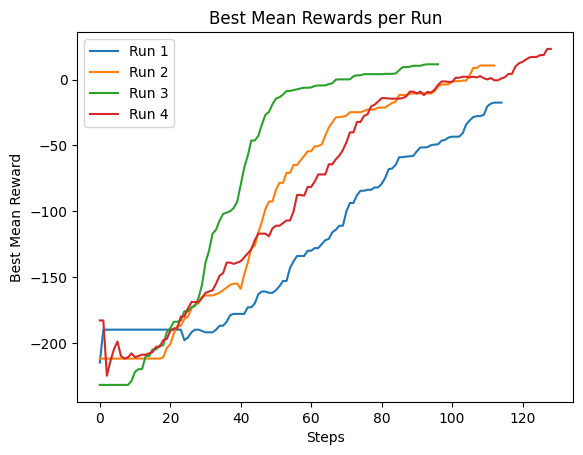

In [34]:
import matplotlib.pyplot as plt

# Tracer les courbes des best_mean_rewards
for i, rewards in enumerate(best_mean_rewards):
    plt.plot(rewards, label=f'Run {i+1}')

plt.xlabel('Steps')
plt.ylabel('Best Mean Reward')
plt.title('Best Mean Rewards per Run')
plt.legend()
plt.show()